In [ ]:
import numpy as np
import seaborn as sb
import matplotlib.pyplot as plt
import h5py
import cv2
import pandas as pd
from sklearn.decomposition import PCA
from pylab import rcParams
from lib import *

rcParams['figure.figsize'] = 12, 12
rcParams['figure.dpi'] = 150

labels = ["20190801_PD44882b_SL41_APCWT_40X_NORMAL_1",
          "20190801_PD44882b_SL54_APCWT_40X_NORMAL_1",
          "20191119_PD407340_SL13_APCHETERO_40X_NORMAL",
          "20191119_PD40734J_SL01_APCNULL_40X_AD_2",
          "20191119_PD42778J_SL03_APCNULL_40X_AD_2"]
data_path = "/Users/josegcpa/DATA/CRYPTS/"

In [2]:
image_dict = {}

with h5py.File(data_path+"NUCLEARSEGMENTATIONPOOR.h5",'r') as image_dataset:
    for key in image_dataset:
        key_root = key[:-4]
        n,crypt_components = cv2.connectedComponents(image_dataset[key]["crypts"][::])
        image_dict[key_root] = {
            "image":image_dataset[key]["image"][::],
            "uncertainty":image_dataset[key]["uncertainty"][::],
            "crypts":image_dataset[key]["crypts"][::],
            "crypt_components":crypt_components,
            "N":n,
            "mask":image_dataset[key]["mask"][::]
        }

instance_masks = np.load(
    data_path + "1_prediction_initial_training.npy",
    allow_pickle=True)

for l,x in zip(labels,instance_masks):
    image_dict[l]['prediction'] = x

# Calculating overlaps and per-object metrics

In [3]:
all_overlaps = {}

for key in image_dict:
    print(key)
    n = image_dict[key]["N"]
    Cs = [x for x in range(1,n+1)]
    element = image_dict[key]
    overlaps = [process_element([element,i]) for i in Cs]
    overlaps = [x for x in overlaps if x is not None]
    all_overlaps[key] = overlaps

20190801_PD44882b_SL41_APCWT_40X_NORMAL_1
20190801_PD44882b_SL54_APCWT_40X_NORMAL_1
20191119_PD407340_SL13_APCHETERO_40X_NORMAL
20191119_PD40734J_SL01_APCNULL_40X_AD_2
20191119_PD42778J_SL03_APCNULL_40X_AD_2


Text(0.5, 1.0, 'predictions and gt stack')

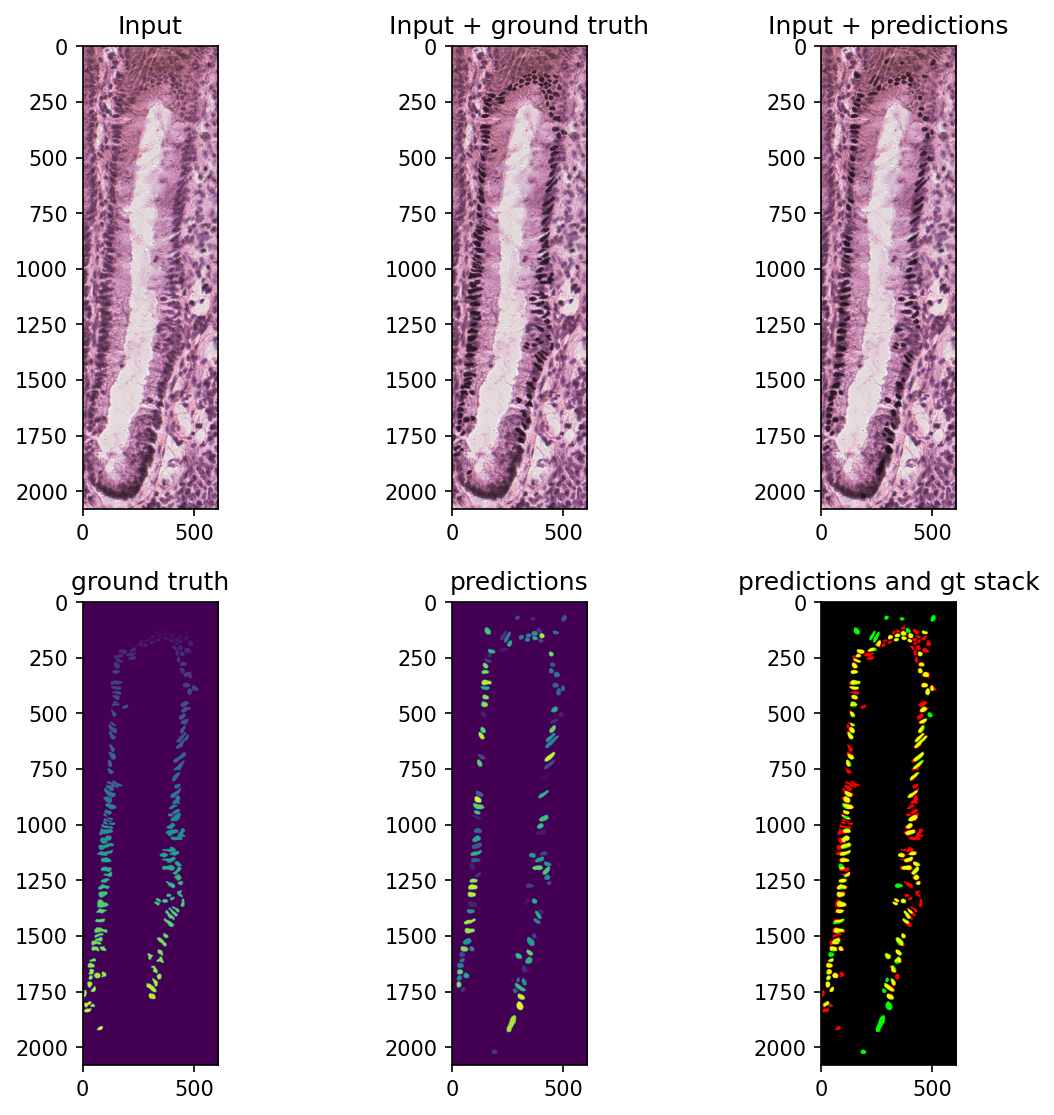

In [4]:
rcParams['figure.figsize'] = 9,9
fig,axes = plt.subplots(2,3)

x = all_overlaps['20190801_PD44882b_SL41_APCWT_40X_NORMAL_1'][1]

wei = np.where(x['mask_components']>0,0.5,1)[:,:,np.newaxis]
wei_pred = np.where(x['prediction_components']>0,0.5,1)[:,:,np.newaxis]
M = np.stack([255*(x['mask_components']>0),
              255*(x['prediction_components']>0),
              np.zeros_like(x['prediction_components'])],axis=2)
axes[0][0].imshow(x["relevant_image"])
axes[0][1].imshow(np.uint8(x["relevant_image"]*wei))
axes[0][2].imshow(np.uint8(x["relevant_image"]*wei_pred))
axes[1][0].imshow(x["mask_components"])
axes[1][1].imshow(x["prediction_components"])
axes[1][2].imshow(M)

axes[0][0].set_title("Input")
axes[0][1].set_title("Input + ground truth")
axes[0][2].set_title("Input + predictions")
axes[1][0].set_title("ground truth")
axes[1][1].set_title("predictions")
axes[1][2].set_title("predictions and gt stack")

Text(0.5, 1.0, 'predictions and gt stack')

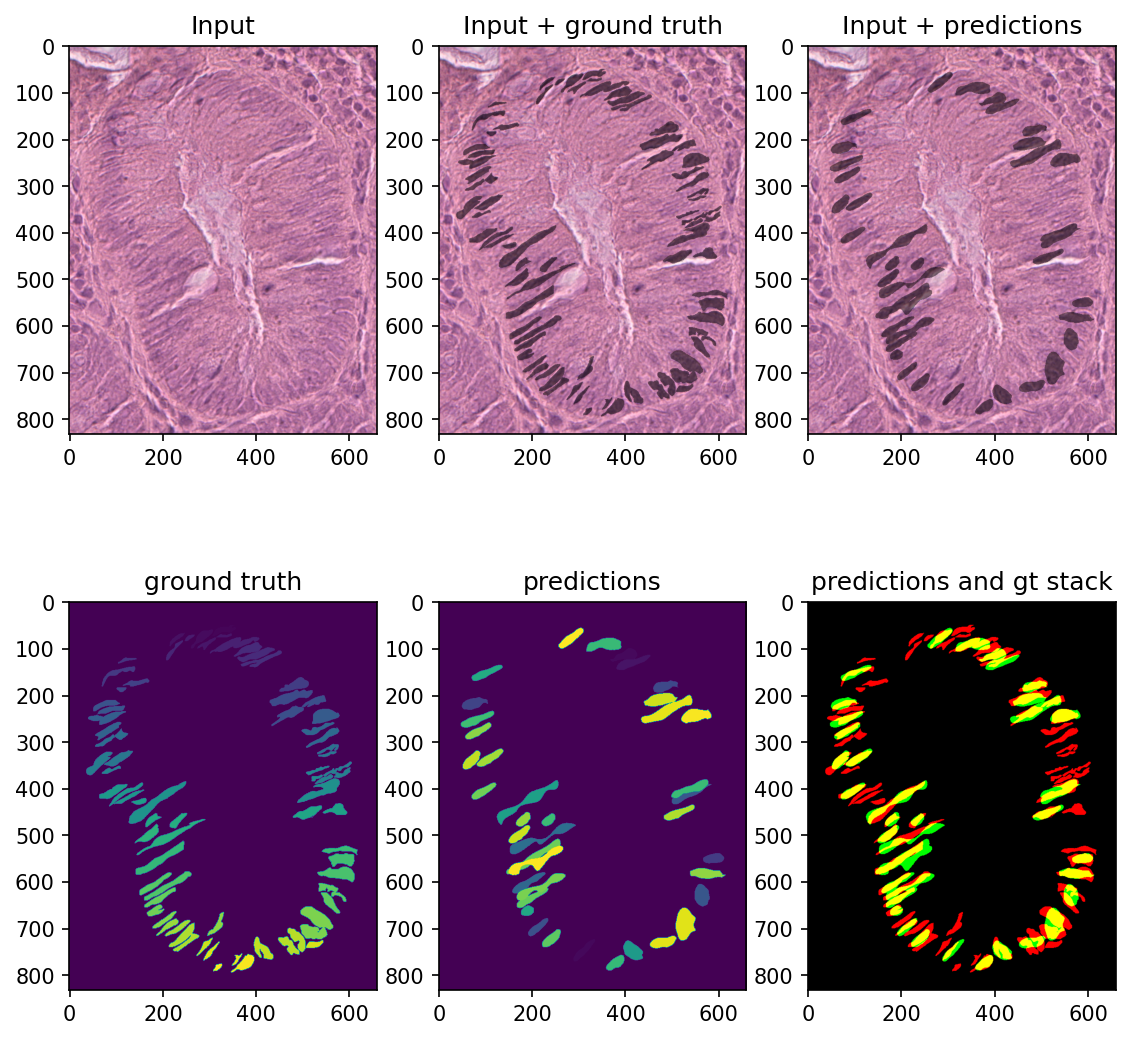

In [5]:
rcParams['figure.figsize'] = 9,9
fig,axes = plt.subplots(2,3)

x = all_overlaps['20191119_PD40734J_SL01_APCNULL_40X_AD_2'][0]

wei = np.where(x['mask_components']>0,0.5,1)[:,:,np.newaxis]
wei_pred = np.where(x['prediction_components']>0,0.5,1)[:,:,np.newaxis]
M = np.stack([255*(x['mask_components']>0),
              255*(x['prediction_components']>0),
              np.zeros_like(x['prediction_components'])],axis=2)
axes[0][0].imshow(x["relevant_image"])
axes[0][1].imshow(np.uint8(x["relevant_image"]*wei))
axes[0][2].imshow(np.uint8(x["relevant_image"]*wei_pred))
axes[1][0].imshow(x["mask_components"])
axes[1][1].imshow(x["prediction_components"])
axes[1][2].imshow(M)

axes[0][0].set_title("Input")
axes[0][1].set_title("Input + ground truth")
axes[0][2].set_title("Input + predictions")
axes[1][0].set_title("ground truth")
axes[1][1].set_title("predictions")
axes[1][2].set_title("predictions and gt stack")

# Colour intensities between crypt and annotated nuclei

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/seaborn/axisgrid.py:316: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/seaborn/axisgrid.py:643: UserWarning: Using the pointplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)


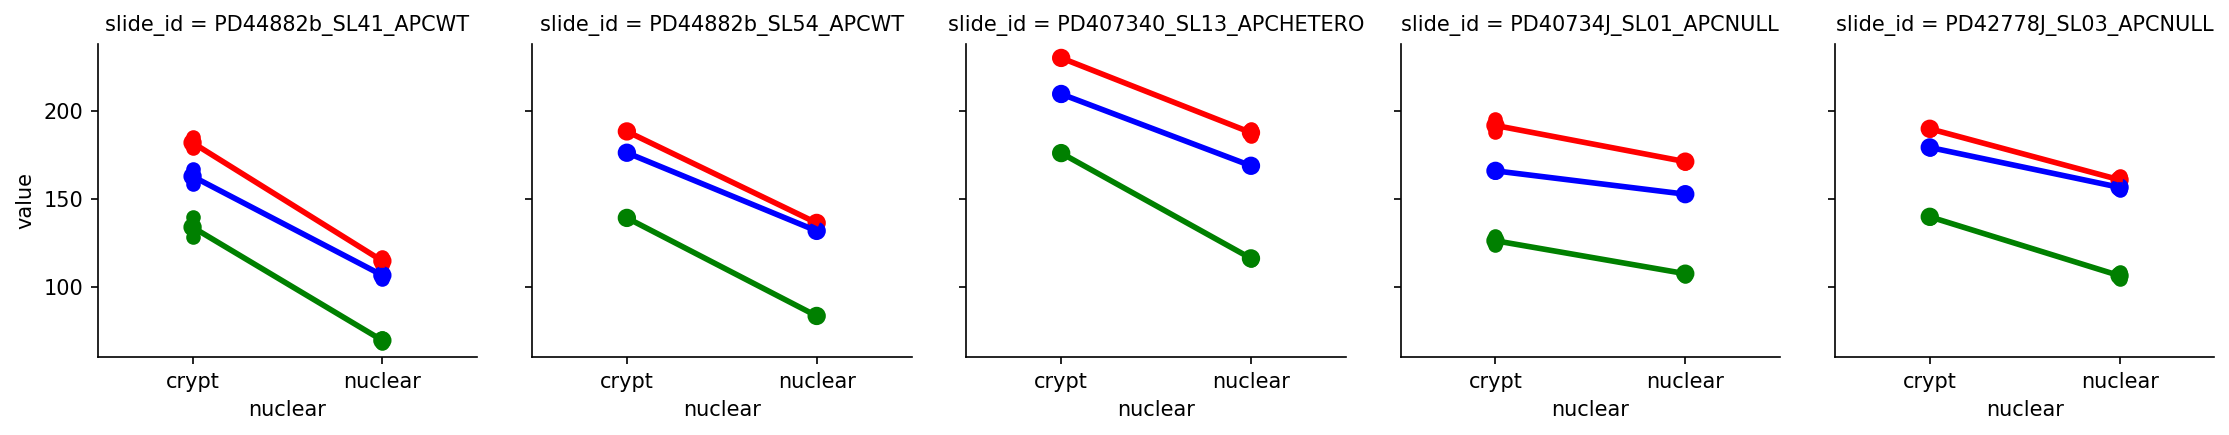

In [6]:
rcParams['figure.figsize'] = 5,5
log_to_nuc = {False:"crypt",True:"nuclear"}
colour_df = {"r":[],"g":[],"b":[],
             "rn":[],"gn":[],"bn":[],
             "slide_id":[],"crypt_id":[]}
for key in all_overlaps:
    key_ = key.split('_')
    key_ = '_'.join([key_[1],key_[2],key_[3]])
    for i,crypt in enumerate(all_overlaps[key]):
        c,n = crypt['colour_summary']
        colour_df['r'].append(c[0])
        colour_df['g'].append(c[1])
        colour_df['b'].append(c[2])
        colour_df['rn'].append(n[0])
        colour_df['gn'].append(n[1])
        colour_df['bn'].append(n[2])
        colour_df['slide_id'].append(key_)
        colour_df['crypt_id'].append(i)
        
colour_df = pd.DataFrame.from_dict(colour_df)
colour_df = pd.melt(colour_df, id_vars=['slide_id','crypt_id'],
                    value_vars=['r','g','b','rn','gn','bn'])
colour_df["nuclear"] = [log_to_nuc['n' in v] for v in colour_df['variable']]
colour_df["variable"] = [x[0] for x in colour_df['variable']]

g = sb.FacetGrid(colour_df,hue="variable",
                 size=3,col="slide_id",
                 palette=["red","green","blue"])
g.map(plt.scatter, "nuclear", "value")
g.map(sb.pointplot, "nuclear", "value")

# Metrics

In [7]:
# mask, pred
metric_df = {
    "idx1":[],"idx2":[],"tp":[],"fp":[],"fn":[],
    "slide_id":[],"crypt_id":[]
}
for k in all_overlaps:
    for i,c in enumerate(all_overlaps[k]):
        metrics = c['metrics']
        for j in ["idx1","idx2","tp","fp","fn"]:
            metric_df[j].extend(metrics[j])
        metric_df["slide_id"].extend([k for _ in metrics['idx1']])
        metric_df["crypt_id"].extend([i for _ in metrics['idx1']])

metric_df = pd.DataFrame.from_dict(metric_df)

## IOU 

This may be a bit problematic since I am assuming that a predicted cell having _>0% IOU_ with an annotated cell means that both masks are describing the same nucleus 

In [8]:
metric_df["IOU"] = metric_df["tp"] / (metric_df["fp"]+metric_df["fn"]+metric_df["tp"])

filtered_metric_df = metric_df.groupby(
    ["idx1","slide_id","crypt_id"]).aggregate({"IOU":np.max})
filtered_metric_df = filtered_metric_df.reset_index()
filtered_metric_df = filtered_metric_df[filtered_metric_df["IOU"] > 0]

[Text(0, 0.5, ''), Text(0.5, 0, 'IOU (Jaccard index)')]

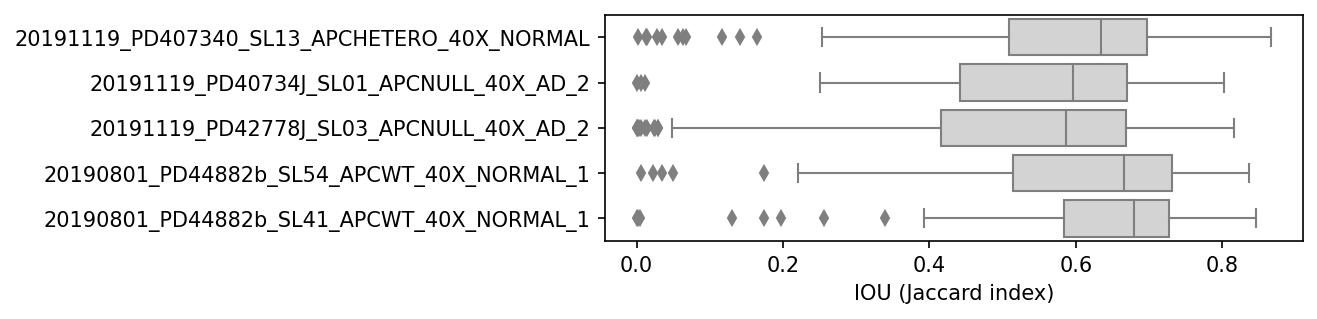

In [9]:
rcParams['figure.figsize'] = 6, 2
p = sb.boxplot(y="slide_id",x="IOU",data=filtered_metric_df,linewidth=1.0,color="lightgrey")
p.set(xlabel='IOU (Jaccard index)', ylabel='')

## Precision at 50% IOU

How many of the annotated nuclei are detected (>50% IOU)

[Text(0, 0.5, ''), Text(0.5, 0, 'Precision at 50% IOU')]

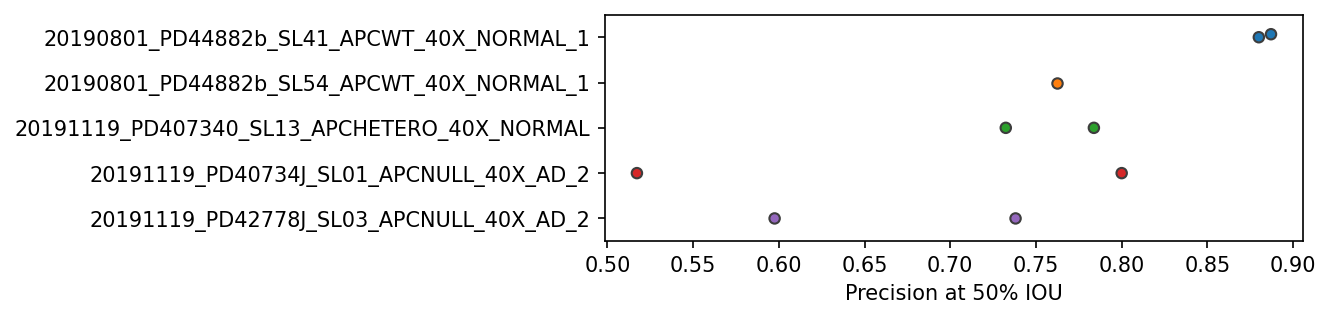

In [10]:
filtered_metric_df["hit"] = filtered_metric_df["IOU"] > 0.5
prec_df = filtered_metric_df.groupby(["slide_id","crypt_id"]).aggregate({"hit":np.sum,"idx1":len}).reset_index()
prec_df["precision"] = prec_df["hit"] / prec_df["idx1"]
rcParams['figure.figsize'] = 6, 2
p = sb.swarmplot(y="slide_id",x="precision",data=prec_df,linewidth=1.0)
p.set(xlabel='Precision at 50% IOU', ylabel='')

## Precision at 70% IOU

How many of the annotated nuclei are detected (>70% IOU)

[Text(0, 0.5, ''), Text(0.5, 0, 'Precision at 50% IOU')]

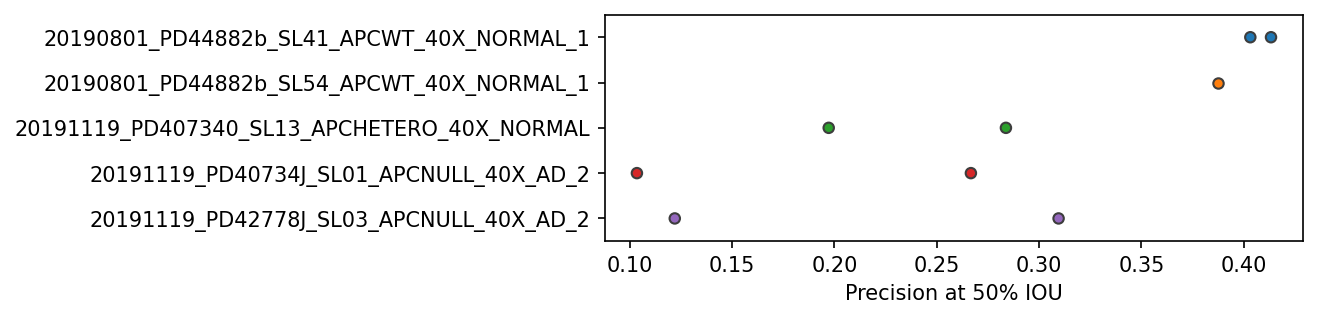

In [11]:
filtered_metric_df["hit"] = filtered_metric_df["IOU"] > 0.7
prec_df = filtered_metric_df.groupby(["slide_id","crypt_id"]).aggregate({"hit":np.sum,"idx1":len}).reset_index()
prec_df["precision"] = prec_df["hit"] / prec_df["idx1"]
rcParams['figure.figsize'] = 6, 2
p = sb.swarmplot(y="slide_id",x="precision",data=prec_df,linewidth=1.0)
p.set(xlabel='Precision at 50% IOU', ylabel='')

## Number of cells per slide

Are we detecting as many cells as are annotated?

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y, data. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


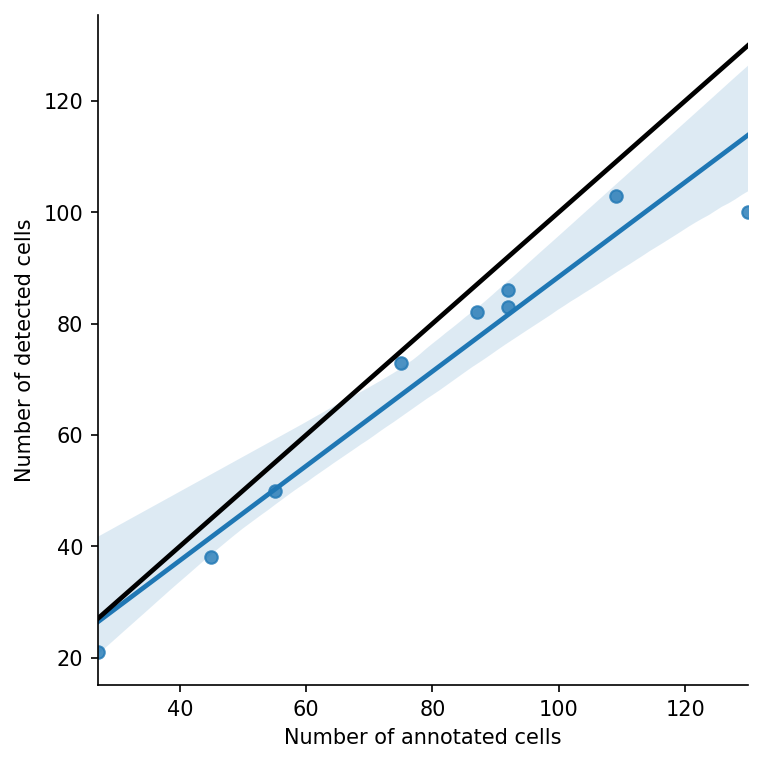

In [62]:
rcParams['figure.figsize'] = 2, 2

n_cells = metric_df.groupby(
    ["slide_id","crypt_id"]).aggregate(
    {"idx1":lambda x: np.unique(x).shape[0],
     "idx2":lambda x: np.unique(x).shape[0]})

p = sb.lmplot('idx1', 'idx2', n_cells,
              sharex=False, sharey=False)
sb.regplot('idx1','idx1',n_cells,ax=p.ax,color='black',
           scatter_kws={'s':0})
p.set(xlabel="Number of annotated cells",
      ylabel="Number of detected cells")

# Calculating summary morphotometry

* Major axis length, minor axis length, ratio of both
* Perimeter, area, ratio of both

In [13]:
pca = PCA(2)
sizes = {}
for key in all_overlaps:
    sizes[key] = {}
    current_set_overlaps = all_overlaps[key]
    for overlap in current_set_overlaps:
        coords = overlap['coords']
        crypt_id = overlap["component_id"]
        sizes[key][crypt_id] = {"mask":[],"pred":[]}
        for mask_coord in coords[0]:
            mask_coord = np.stack(mask_coord,axis=1)
            area = mask_coord.shape[0]
            perimeter = cv2.arcLength(mask_coord,True)
            mask_coords_pca = pca.fit_transform(mask_coord)
            m1,M1 = mask_coords_pca[:,0].min(),mask_coords_pca[:,0].max()
            m2,M2 = mask_coords_pca[:,1].min(),mask_coords_pca[:,1].max()
            sizes[key][crypt_id]["mask"].append([M1 - m1,M2 - m2,area,perimeter])

        for pred_coord in coords[1]:
            pred_coord = np.stack(pred_coord,axis=1)
            area = pred_coord.shape[0]
            perimeter = cv2.arcLength(pred_coord,True)
            pred_coords_pca = pca.fit_transform(pred_coord)
            m1,M1 = pred_coords_pca[:,0].min(),pred_coords_pca[:,0].max()
            m2,M2 = pred_coords_pca[:,1].min(),pred_coords_pca[:,1].max()
            sizes[key][crypt_id]["pred"].append([M1 - m1,M2 - m2,area,perimeter])

In [14]:
size_df = {"crypt_id":[],"slide_id":[],
           "a":[],"b":[],"id":[],"area":[],"perimeter":[],
           "apc_status":[]}

for key in sizes:
    for crypt in sizes[key]:
        V = sizes[key][crypt]
        size_df["slide_id"].extend([key for i in range(len(V["mask"]))])
        size_df["crypt_id"].extend([crypt for i in range(len(V["mask"]))])
        size_df["a"].extend([x[0] for x in V["mask"]])
        size_df["b"].extend([x[1] for x in V["mask"]])
        size_df["area"].extend([x[2] for x in V["mask"]])  
        size_df["perimeter"].extend([x[3] for x in V["mask"]])
        size_df["id"].extend(["mask" for i in range(len(V["mask"]))])
        if "APCNULL" in key:
            apc_status = "APCNULL"
        elif "APCWT" in key:
            apc_status = "APCWT"
        else:
            apc_status = "APCHETERO"
        size_df["apc_status"].extend([apc_status for i in range(len(V["mask"]))])

        
        size_df["slide_id"].extend([key for i in range(len(V["pred"]))])
        size_df["crypt_id"].extend([crypt for i in range(len(V["pred"]))])
        size_df["a"].extend([x[0] for x in V["pred"]])
        size_df["b"].extend([x[1] for x in V["pred"]])
        size_df["area"].extend([x[2] for x in V["pred"]])
        size_df["perimeter"].extend([x[3] for x in V["pred"]])
        size_df["id"].extend(["pred" for i in range(len(V["pred"]))])
        if "APCNULL" in key:
            apc_status = "APCNULL"
        elif "APCWT" in key:
            apc_status = "APCWT"
        else:
            apc_status = "APCHETERO"
        size_df["apc_status"].extend([apc_status for i in range(len(V["pred"]))])


size_df = pd.DataFrame.from_dict(size_df)
size_df["slide_crypt_id"] = [str(x)+" "+str(y) for x,y in zip(size_df["slide_id"],size_df["crypt_id"])]
size_df["ab_ratio"] = size_df["a"] / size_df["b"]
size_df["perimeter_area_ratio"] = size_df["perimeter"] / size_df["area"]

alpha = 0.4
lwd = 2.5

## Between slides

### Major axis

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/seaborn/categorical.py:2999: UserWarning: The `split` parameter has been renamed to `dodge`.
  warnings.warn(msg, UserWarning)
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/seaborn/categorical.py:1296: UserWarning: 27.9% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/seaborn/categorical.py:1296: UserWarning: 31.6% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/seaborn/categorical.py:1296: UserWarning: 45.3% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/Library/Framework

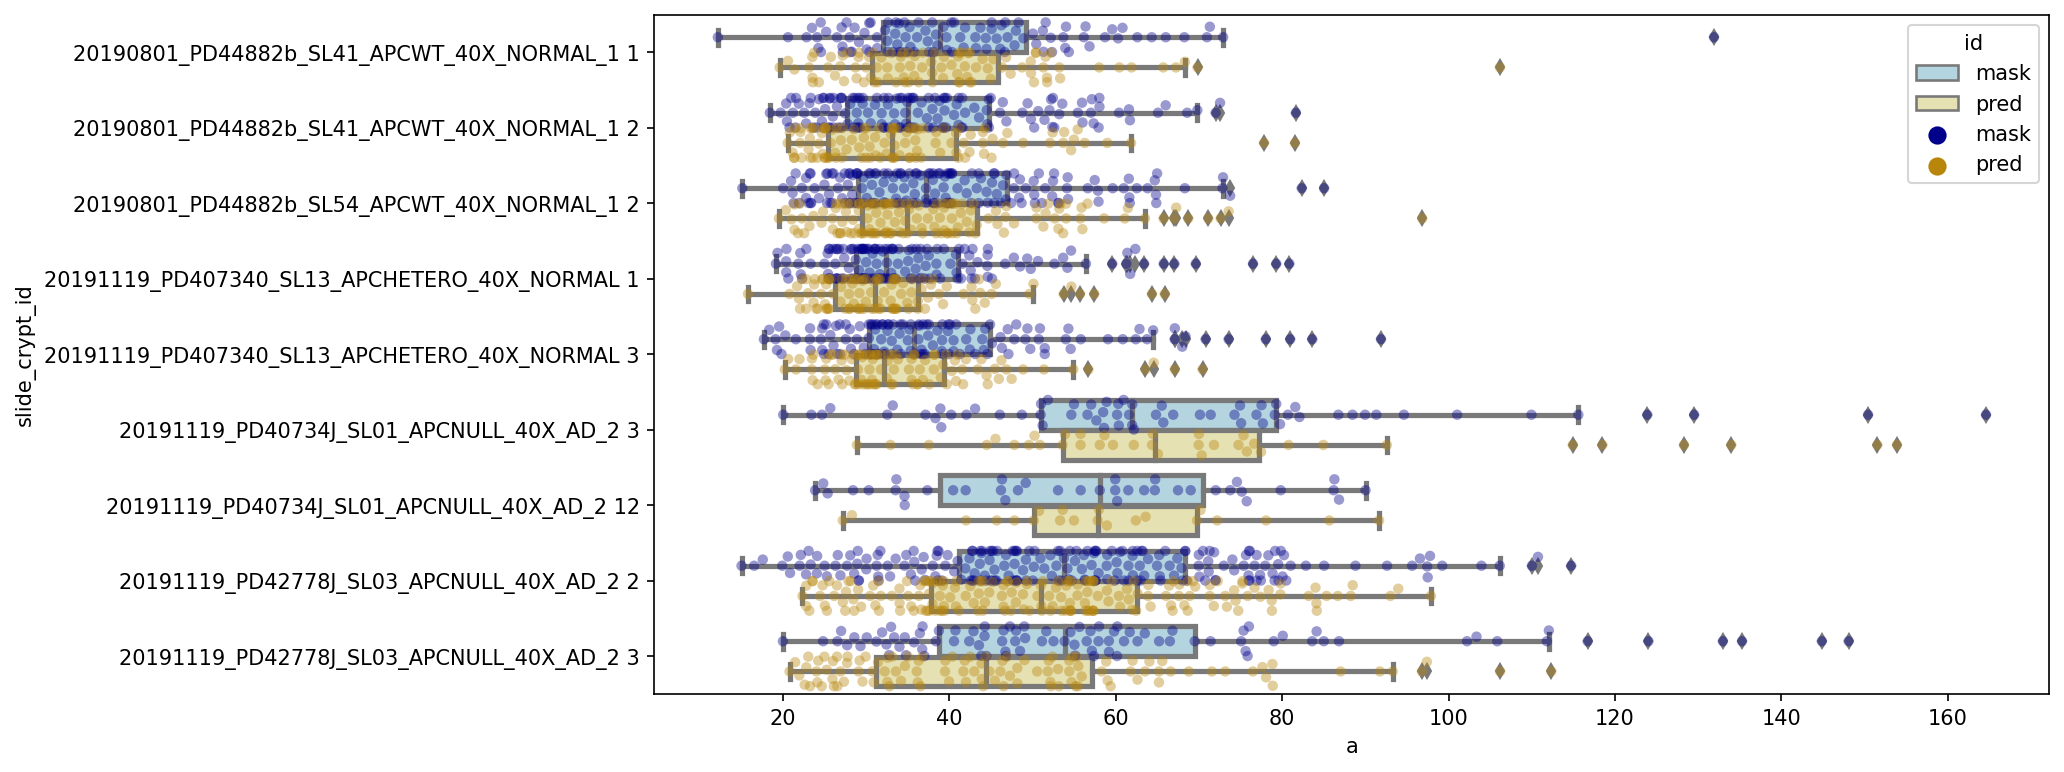

In [15]:
rcParams['figure.figsize'] = 12, 6
sb.boxplot(x="a",y="slide_crypt_id",data=size_df,hue="id",
           palette=['lightblue',"palegoldenrod"],linewidth=lwd)
sb.swarmplot(y="slide_crypt_id",x="a",data=size_df,hue="id",split=True,
             palette=["darkblue","darkgoldenrod"],alpha=alpha)
plt.show()

### Minor axis

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/seaborn/categorical.py:2999: UserWarning: The `split` parameter has been renamed to `dodge`.
  warnings.warn(msg, UserWarning)
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/seaborn/categorical.py:1296: UserWarning: 31.7% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/seaborn/categorical.py:1296: UserWarning: 37.9% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/seaborn/categorical.py:1296: UserWarning: 45.3% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/Library/Framework

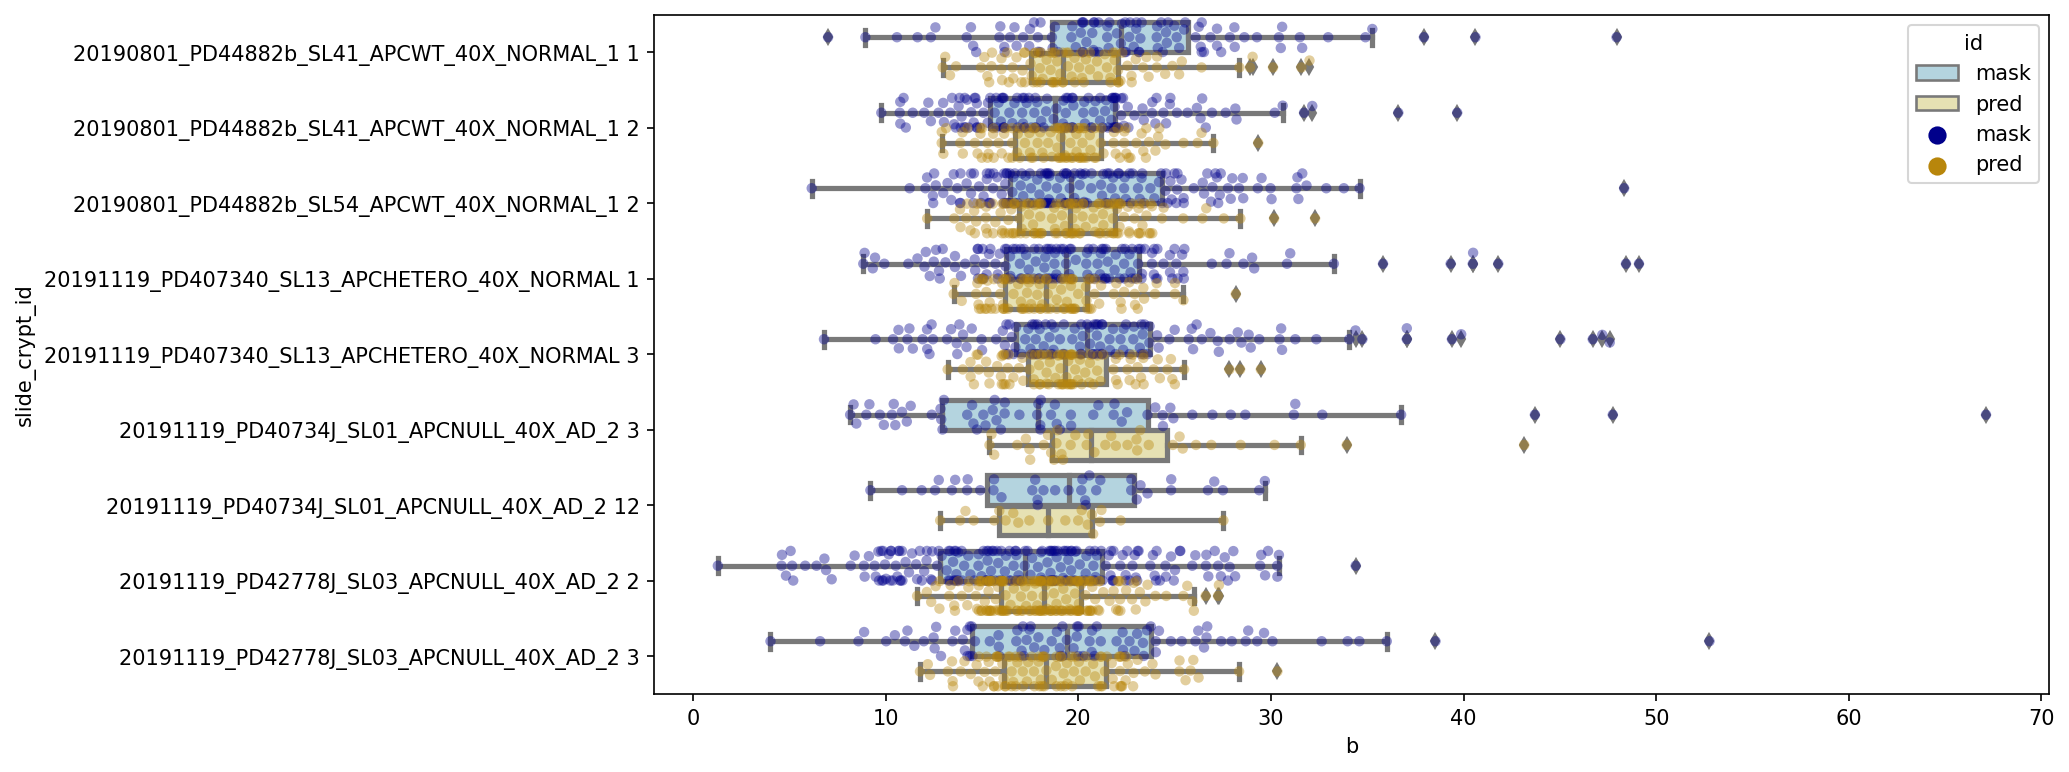

In [16]:
rcParams['figure.figsize'] = 12, 6
sb.boxplot(x="b",y="slide_crypt_id",data=size_df,hue="id",
           palette=['lightblue',"palegoldenrod"],linewidth=lwd)
sb.swarmplot(y="slide_crypt_id",x="b",data=size_df,hue="id",split=True,
             palette=["darkblue","darkgoldenrod"],alpha=alpha)
plt.show()

### Major axis/minor axis ratio

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/seaborn/categorical.py:2999: UserWarning: The `split` parameter has been renamed to `dodge`.
  warnings.warn(msg, UserWarning)
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/seaborn/categorical.py:1296: UserWarning: 45.2% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/seaborn/categorical.py:1296: UserWarning: 41.1% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/seaborn/categorical.py:1296: UserWarning: 57.4% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/Library/Framework

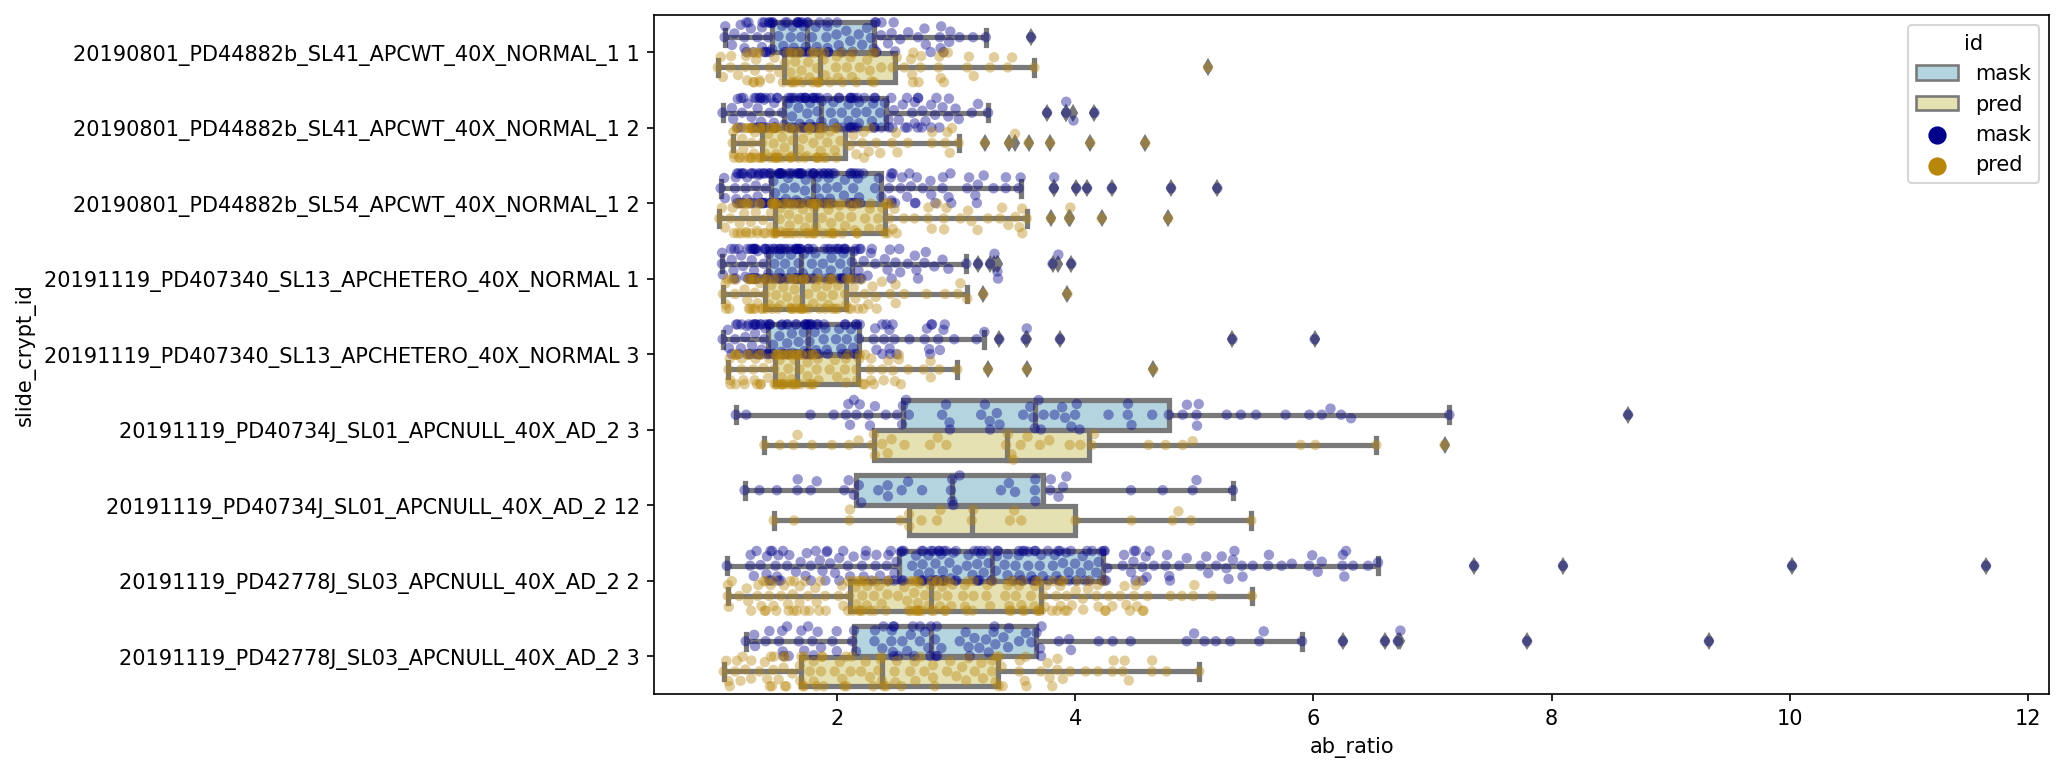

In [17]:
rcParams['figure.figsize'] = 12, 6
sb.boxplot(x="ab_ratio",y="slide_crypt_id",data=size_df,hue="id",
           palette=['lightblue',"palegoldenrod"],linewidth=lwd)
sb.swarmplot(y="slide_crypt_id",x="ab_ratio",data=size_df,hue="id",split=True,
             palette=["darkblue","darkgoldenrod"],alpha=alpha)
plt.show()

### Area

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/seaborn/categorical.py:2999: UserWarning: The `split` parameter has been renamed to `dodge`.
  warnings.warn(msg, UserWarning)
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/seaborn/categorical.py:1296: UserWarning: 27.9% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/seaborn/categorical.py:1296: UserWarning: 40.0% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/seaborn/categorical.py:1296: UserWarning: 52.0% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/Library/Framework

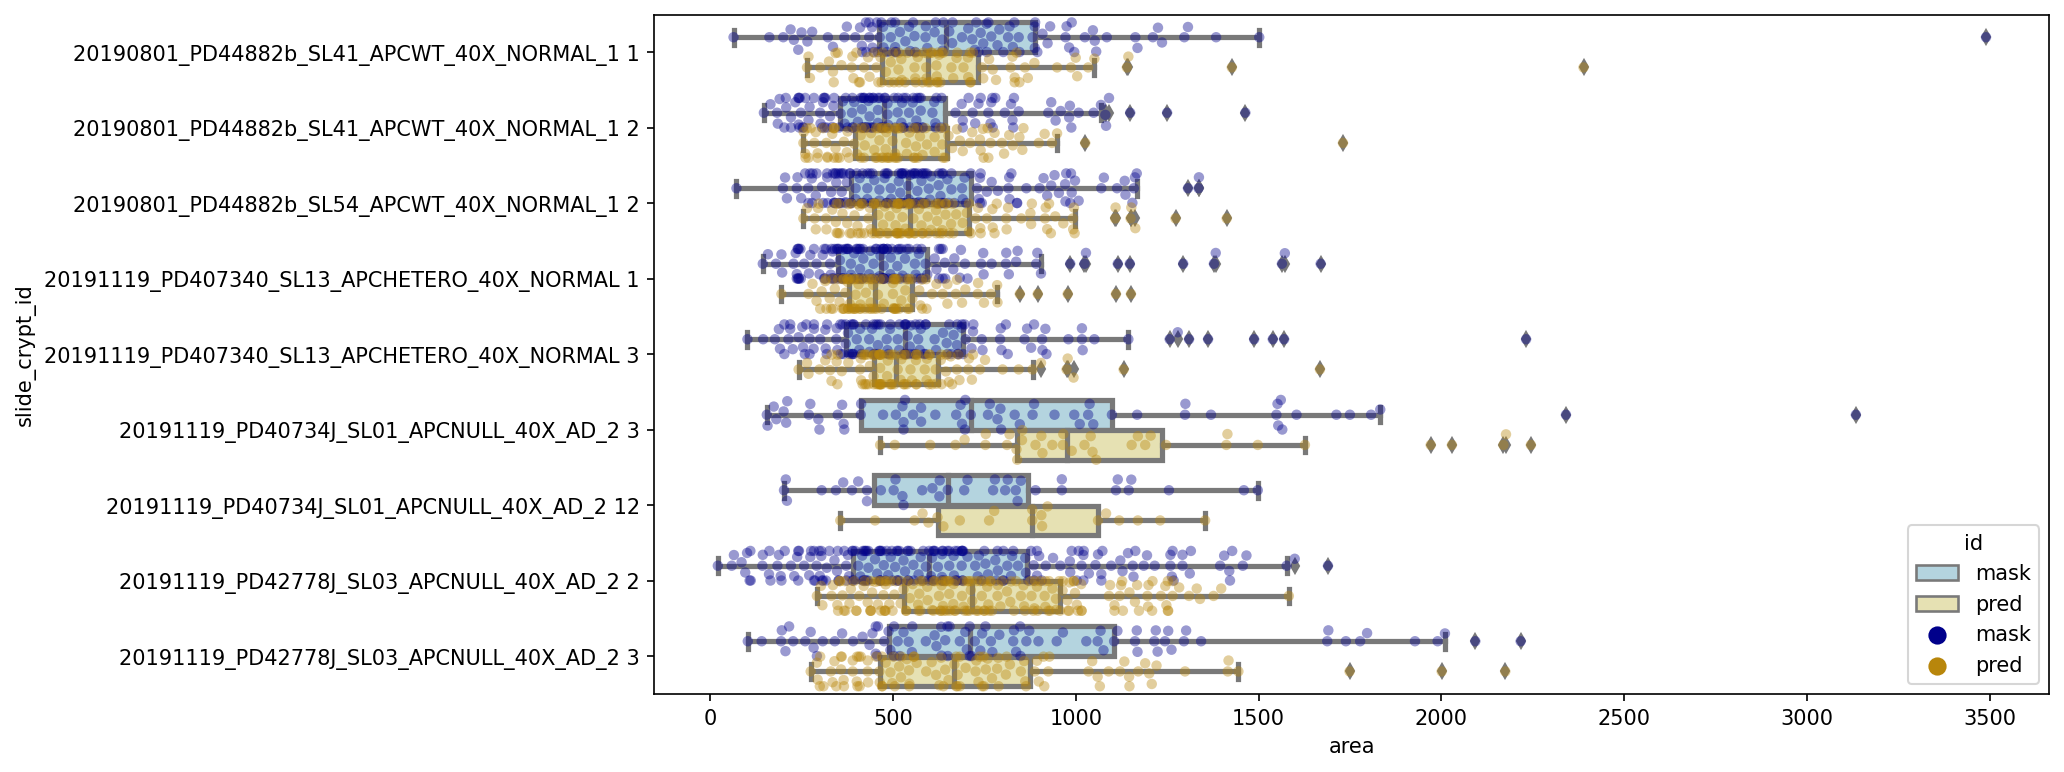

In [18]:
rcParams['figure.figsize'] = 12, 6
sb.boxplot(x="area",y="slide_crypt_id",data=size_df,hue="id",
           palette=['lightblue',"palegoldenrod"],linewidth=lwd)
sb.swarmplot(y="slide_crypt_id",x="area",data=size_df,hue="id",split=True,
             palette=["darkblue","darkgoldenrod"],alpha=alpha)
plt.show()

### Perimeter

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/seaborn/categorical.py:2999: UserWarning: The `split` parameter has been renamed to `dodge`.
  warnings.warn(msg, UserWarning)
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/seaborn/categorical.py:1296: UserWarning: 32.7% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/seaborn/categorical.py:1296: UserWarning: 34.7% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/seaborn/categorical.py:1296: UserWarning: 49.3% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/Library/Framework

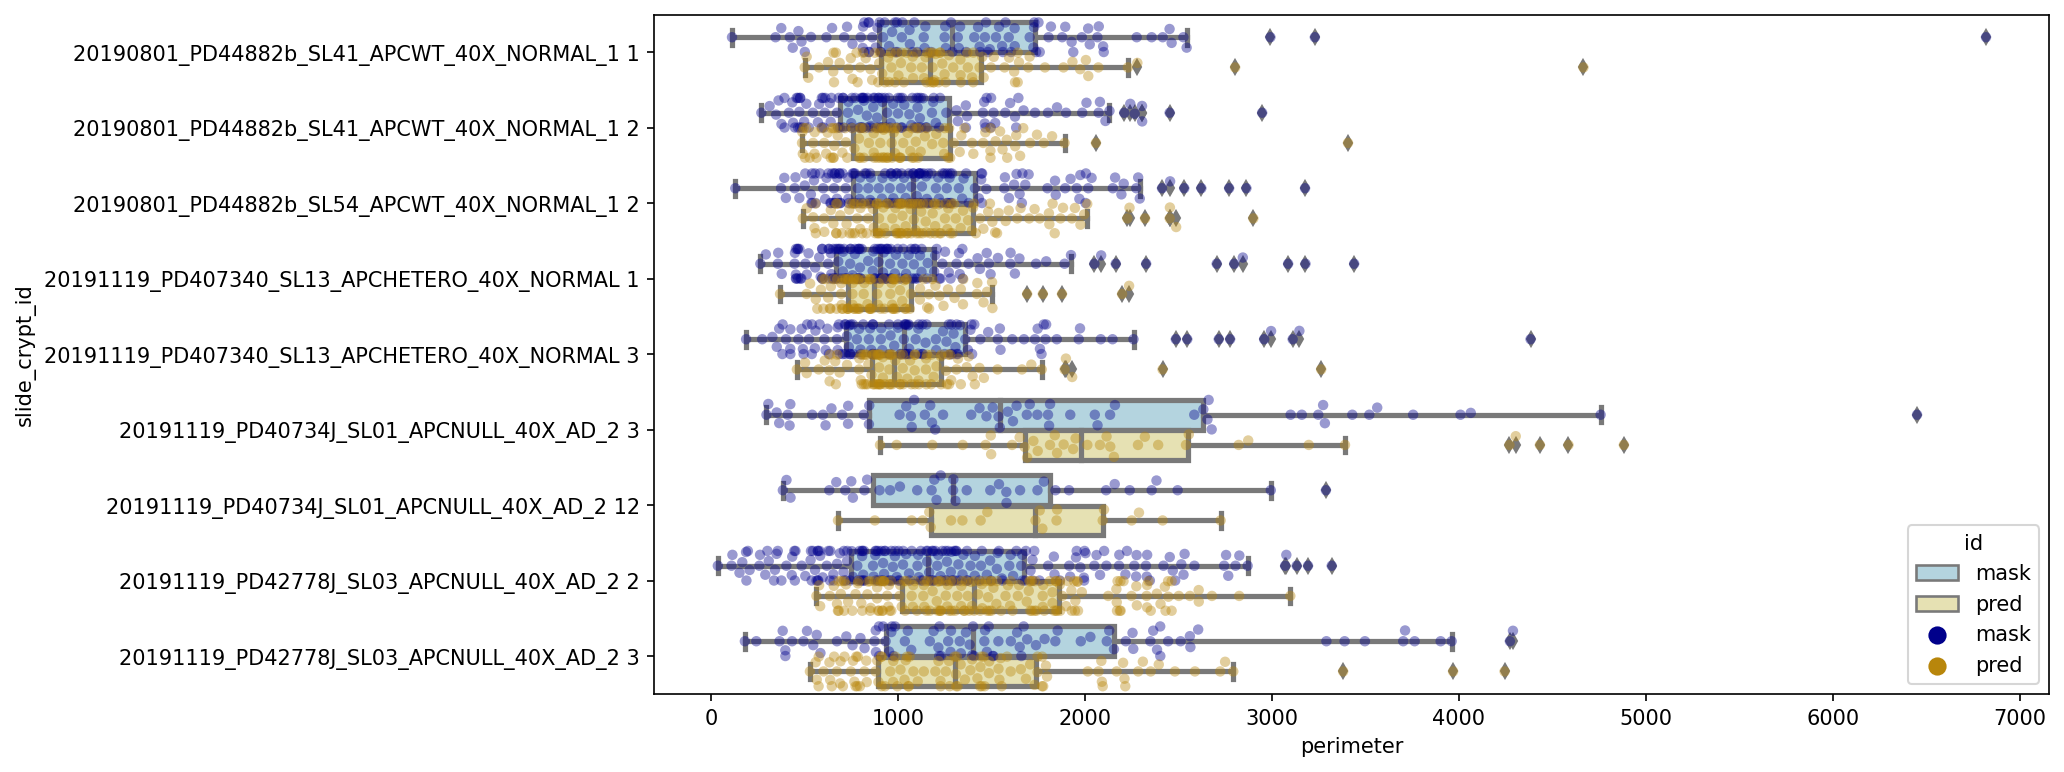

In [19]:
rcParams['figure.figsize'] = 12, 6
sb.boxplot(x="perimeter",y="slide_crypt_id",data=size_df,hue="id",
           palette=['lightblue',"palegoldenrod"],linewidth=lwd)
sb.swarmplot(y="slide_crypt_id",x="perimeter",data=size_df,hue="id",split=True,
             palette=["darkblue","darkgoldenrod"],alpha=alpha)
plt.show()

### Perimeter/area ratio

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/seaborn/categorical.py:2999: UserWarning: The `split` parameter has been renamed to `dodge`.
  warnings.warn(msg, UserWarning)
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/seaborn/categorical.py:1296: UserWarning: 54.8% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/seaborn/categorical.py:1296: UserWarning: 57.9% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/seaborn/categorical.py:1296: UserWarning: 56.8% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/Library/Framework

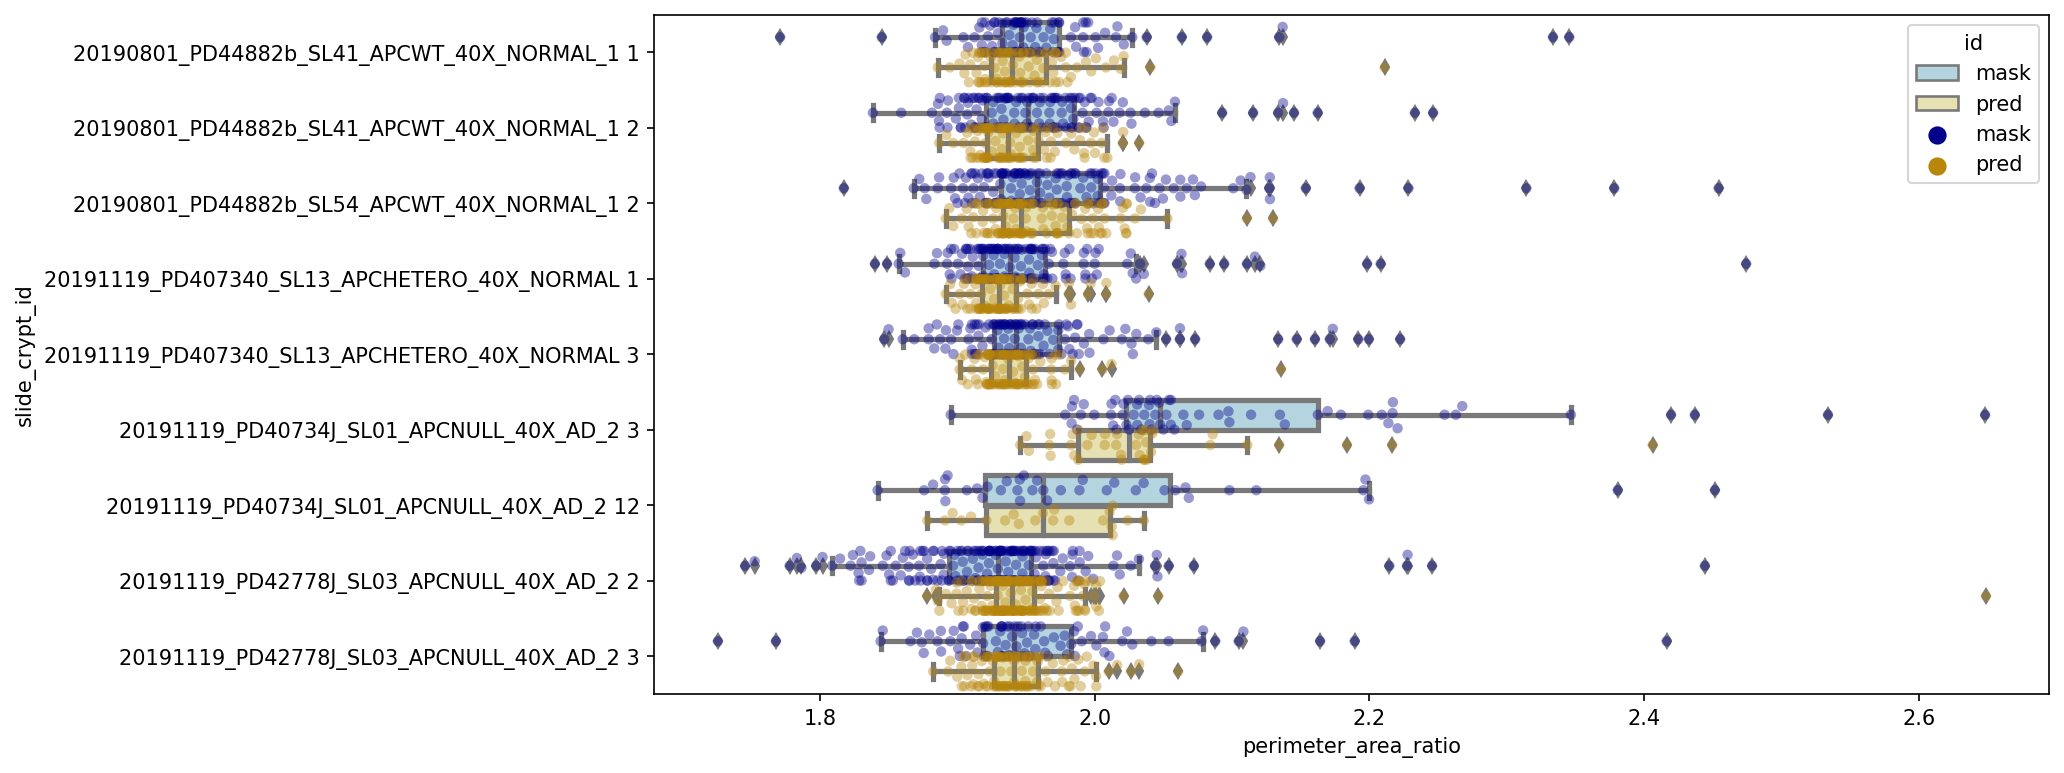

In [20]:
rcParams['figure.figsize'] = 12, 6
sb.boxplot(x="perimeter_area_ratio",y="slide_crypt_id",data=size_df,hue="id",
           palette=['lightblue',"palegoldenrod"],linewidth=lwd)
sb.swarmplot(y="slide_crypt_id",x="perimeter_area_ratio",data=size_df,hue="id",split=True,
             palette=["darkblue","darkgoldenrod"],alpha=alpha)
plt.show()

## Between APC status

For this analysis we exclude the slide `20191119_PD40734J_SL01_APCNULL_40X_AD_2` because it has a distinctly different preparation.

In [21]:
size_df_ = size_df[size_df["slide_id"] != "20191119_PD40734J_SL01_APCNULL_40X_AD_2"]

### Major axis

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/seaborn/categorical.py:2999: UserWarning: The `split` parameter has been renamed to `dodge`.
  warnings.warn(msg, UserWarning)
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/seaborn/categorical.py:1296: UserWarning: 49.2% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/seaborn/categorical.py:1296: UserWarning: 39.7% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/seaborn/categorical.py:1296: UserWarning: 21.8% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/Library/Framework

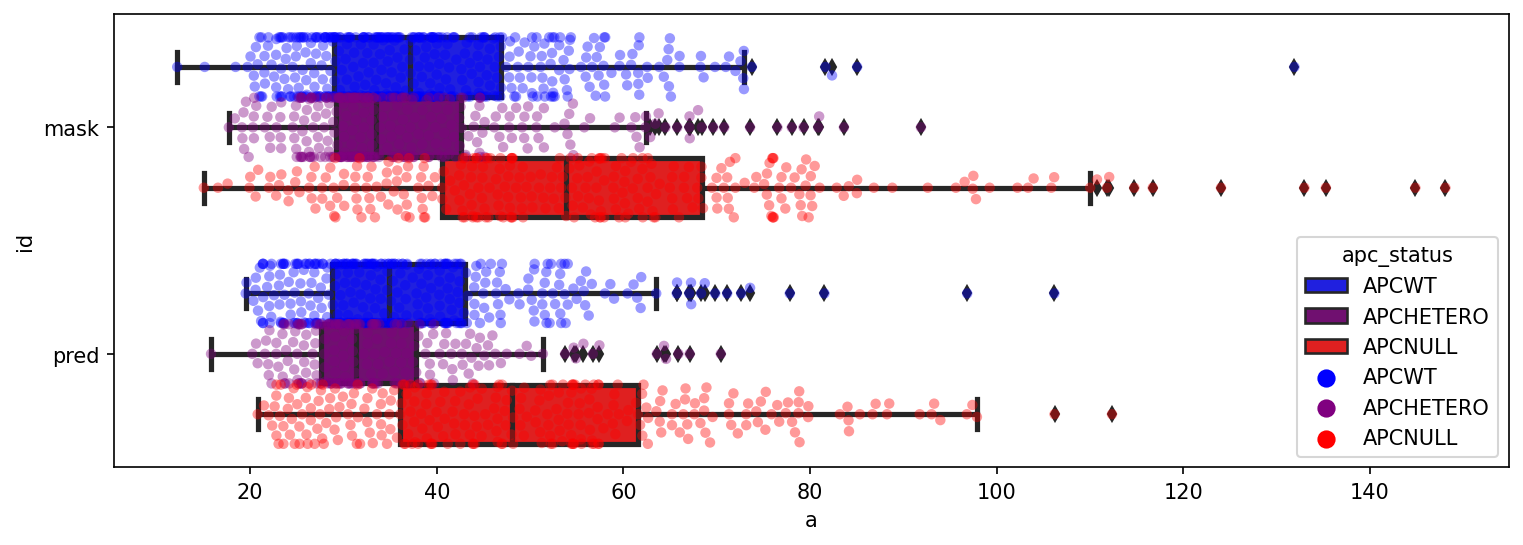

In [22]:
rcParams['figure.figsize'] = 12, 4
sb.boxplot(x="a",y="id",data=size_df_,hue="apc_status",
           palette=['blue',"purple","red"],linewidth=lwd)
sb.swarmplot(y="id",x="a",data=size_df_,hue="apc_status",split=True,
             palette=['blue',"purple","red"],alpha=alpha)
plt.show()

### Minor axis

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/seaborn/categorical.py:2999: UserWarning: The `split` parameter has been renamed to `dodge`.
  warnings.warn(msg, UserWarning)
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/seaborn/categorical.py:1296: UserWarning: 43.7% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/seaborn/categorical.py:1296: UserWarning: 27.9% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/seaborn/categorical.py:1296: UserWarning: 25.3% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/Library/Framework

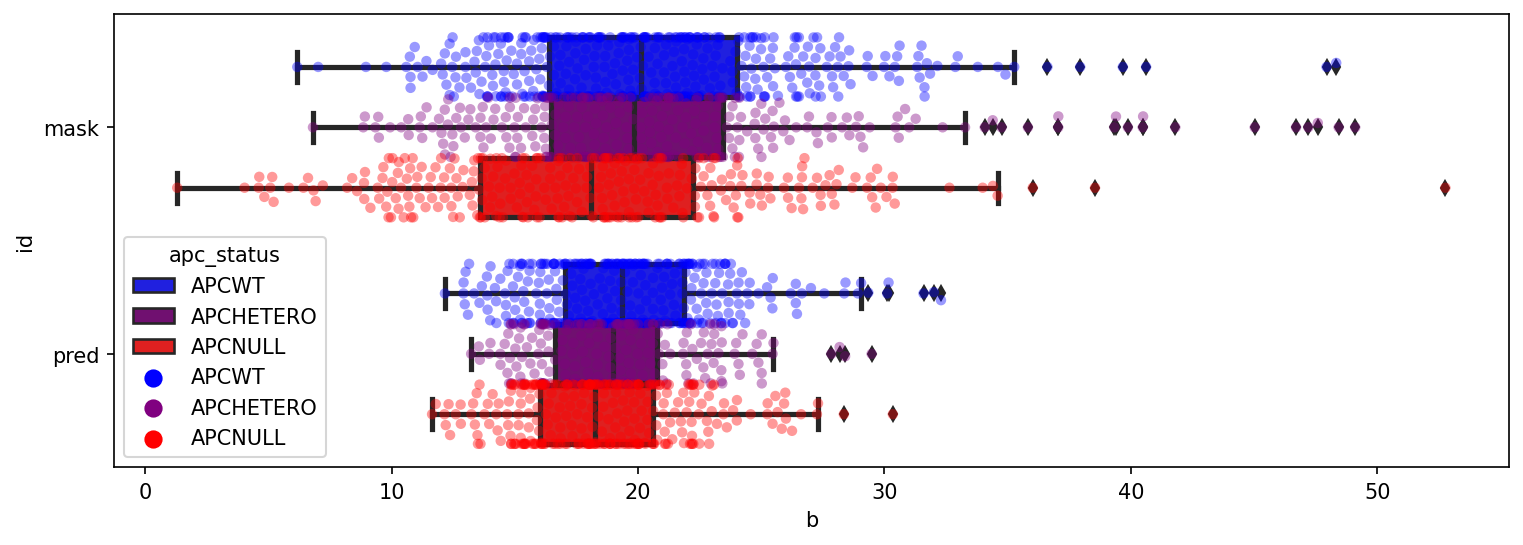

In [23]:
rcParams['figure.figsize'] = 12, 4
sb.boxplot(x="b",y="id",data=size_df_,hue="apc_status",
           palette=['blue',"purple","red"],linewidth=lwd)
sb.swarmplot(y="id",x="b",data=size_df_,hue="apc_status",split=True,
             palette=['blue',"purple","red"],alpha=alpha)
plt.show()

### Major axis/minor axis ratio

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/seaborn/categorical.py:2999: UserWarning: The `split` parameter has been renamed to `dodge`.
  warnings.warn(msg, UserWarning)
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/seaborn/categorical.py:1296: UserWarning: 64.6% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/seaborn/categorical.py:1296: UserWarning: 55.5% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/seaborn/categorical.py:1296: UserWarning: 28.2% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/Library/Framework

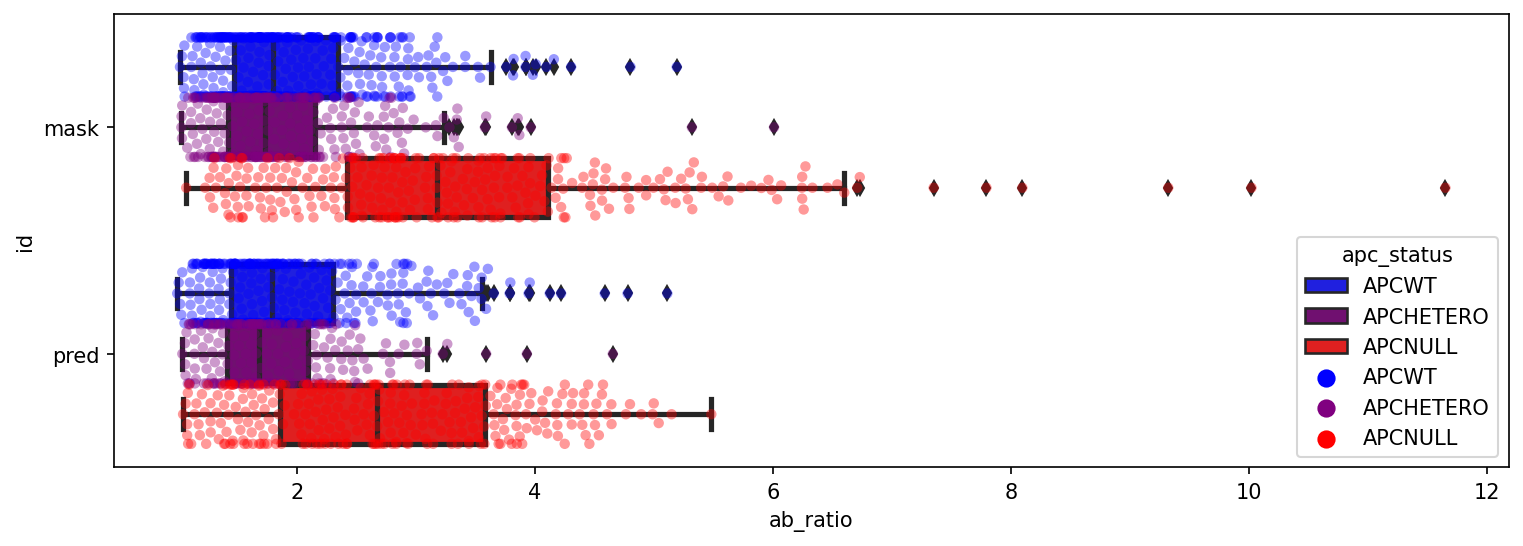

In [24]:
rcParams['figure.figsize'] = 12, 4
sb.boxplot(x="ab_ratio",y="id",data=size_df_,hue="apc_status",
           palette=['blue',"purple","red"],linewidth=lwd)
sb.swarmplot(y="id",x="ab_ratio",data=size_df_,hue="apc_status",split=True,
             palette=['blue',"purple","red"],alpha=alpha)
plt.show()

### Area

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/seaborn/categorical.py:2999: UserWarning: The `split` parameter has been renamed to `dodge`.
  warnings.warn(msg, UserWarning)
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/seaborn/categorical.py:1296: UserWarning: 54.9% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/seaborn/categorical.py:1296: UserWarning: 47.6% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/seaborn/categorical.py:1296: UserWarning: 32.4% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/Library/Framework

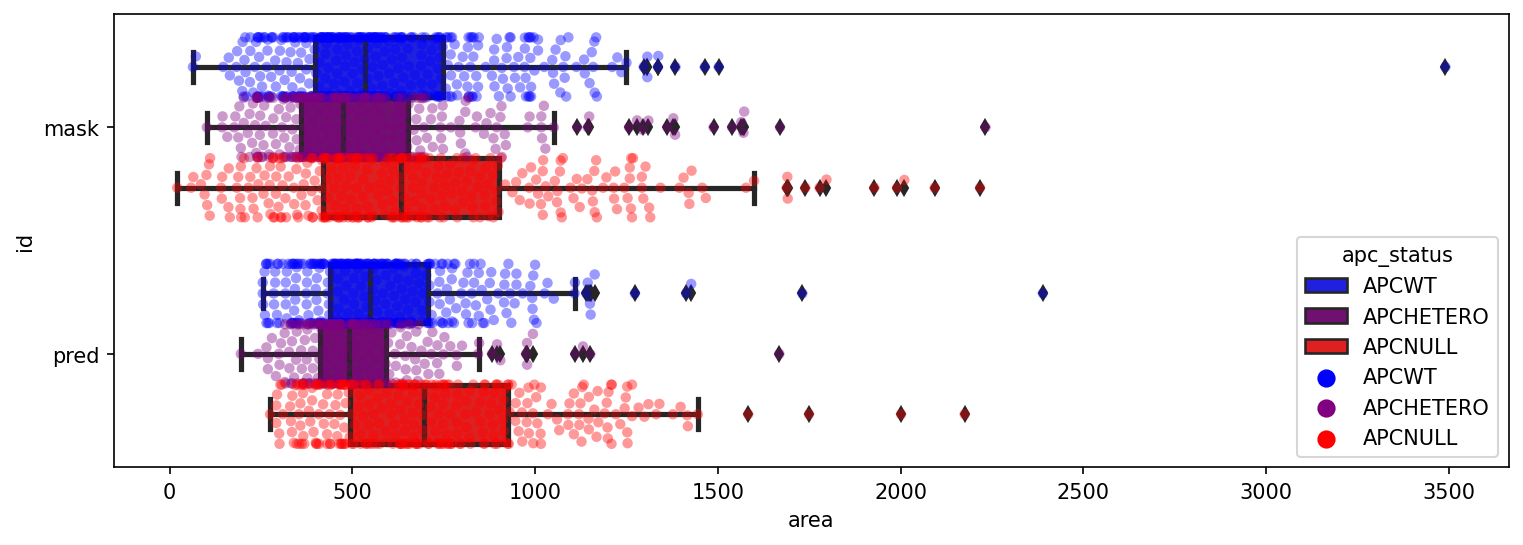

In [25]:
rcParams['figure.figsize'] = 12, 4
sb.boxplot(x="area",y="id",data=size_df_,hue="apc_status",
           palette=['blue',"purple","red"],linewidth=lwd)
sb.swarmplot(y="id",x="area",data=size_df_,hue="apc_status",split=True,
             palette=['blue',"purple","red"],alpha=alpha)
plt.show()

### Perimeter

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/seaborn/categorical.py:2999: UserWarning: The `split` parameter has been renamed to `dodge`.
  warnings.warn(msg, UserWarning)
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/seaborn/categorical.py:1296: UserWarning: 53.9% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/seaborn/categorical.py:1296: UserWarning: 47.9% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/seaborn/categorical.py:1296: UserWarning: 30.8% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/Library/Framework

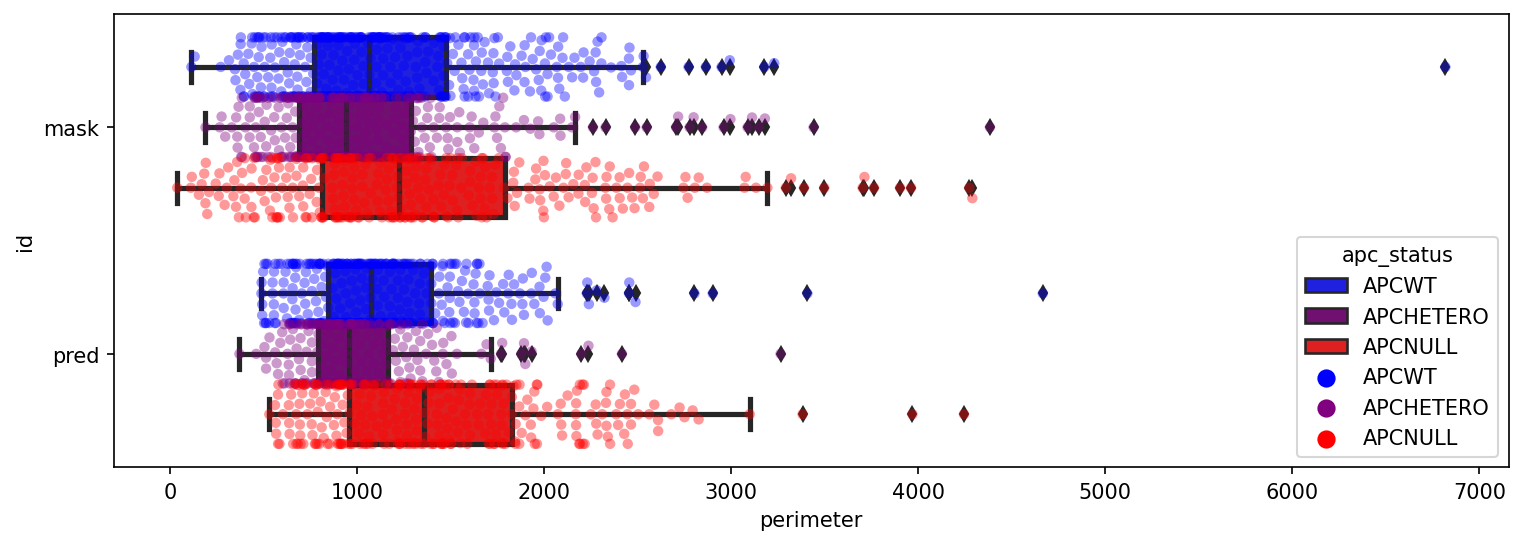

In [26]:
rcParams['figure.figsize'] = 12, 4
sb.boxplot(x="perimeter",y="id",data=size_df_,hue="apc_status",
           palette=['blue',"purple","red"],linewidth=lwd)
sb.swarmplot(y="id",x="perimeter",data=size_df_,hue="apc_status",split=True,
             palette=['blue',"purple","red"],alpha=alpha)
plt.show()

### Perimeter/area ratio

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/seaborn/categorical.py:2999: UserWarning: The `split` parameter has been renamed to `dodge`.
  warnings.warn(msg, UserWarning)
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/seaborn/categorical.py:1296: UserWarning: 62.0% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/seaborn/categorical.py:1296: UserWarning: 54.8% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/seaborn/categorical.py:1296: UserWarning: 49.7% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/Library/Framework

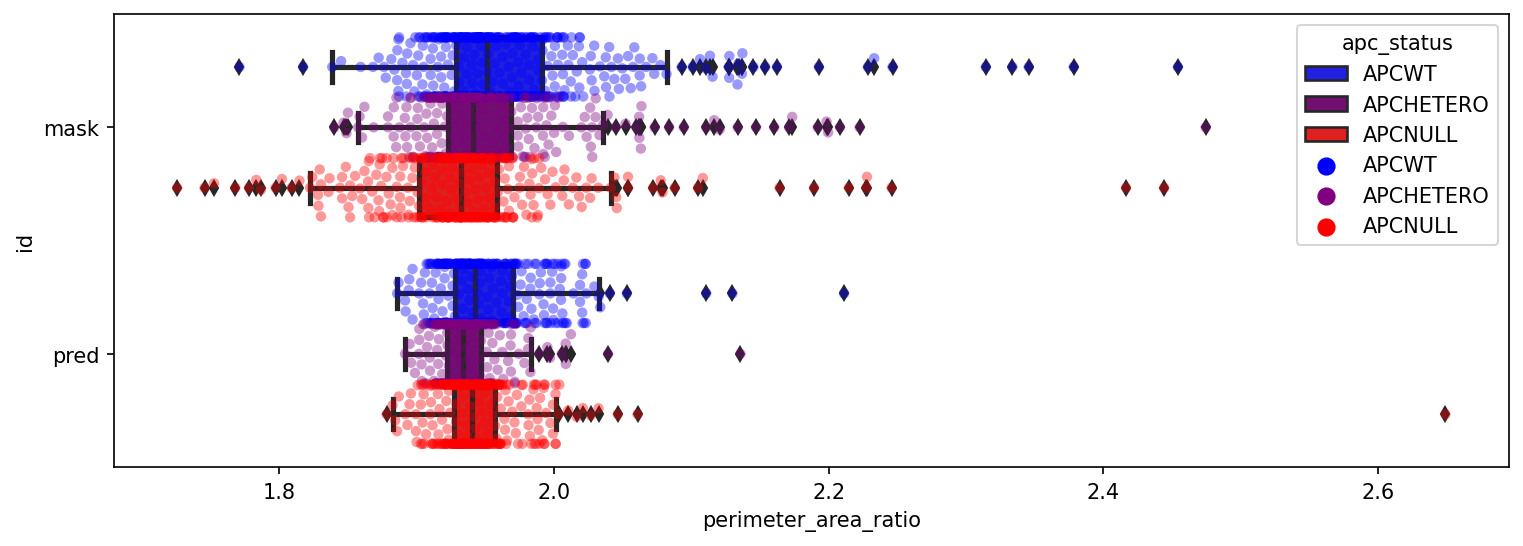

In [27]:
rcParams['figure.figsize'] = 12, 4
sb.boxplot(x="perimeter_area_ratio",y="id",data=size_df_,hue="apc_status",
           palette=['blue',"purple","red"],linewidth=lwd)
sb.swarmplot(y="id",x="perimeter_area_ratio",data=size_df_,hue="apc_status",split=True,
             palette=['blue',"purple","red"],alpha=alpha)
plt.show()